<a href="https://colab.research.google.com/github/Amulyareddy2002/Sign-Language-Recognition/blob/master/sign_language_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import Data

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! kaggle datasets download -d datamunge/sign-language-mnist

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 78% 49.0M/62.6M [00:01<00:00, 71.6MB/s]
100% 62.6M/62.6M [00:01<00:00, 59.0MB/s]


In [4]:
! unzip /content/sign-language-mnist.zip

Archive:  /content/sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [5]:
train = pd.read_csv('/content/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')

In [ ]:
train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
X = train.drop(['label'], axis = 1)
y = train['label']

In [7]:
X.shape, y.shape

((27455, 784), (27455,))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Hyperparameters

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 28
NUM_CLASS = y.nunique() + 1

# Preprocessing and Data Loader

In [10]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 30 degrees
    # transforms.RandomResizedCrop(IMAGE_SIZE),  # Randomly crop and resize the image to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
])

# Define the fixed transformations
fixed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define the overall transformation pipeline
transform = transforms.Compose([
    transforms.RandomApply([random_transforms], p=0.5),  # Apply random transformations with a probability of 0.5
    fixed_transforms
])

In [11]:
class SignDataSet(Dataset):
  def __init__(
      self,
      image_df,
      label_df,
      transform,
      split = None,
  ):
    self.image_df = image_df
    self.label_df = torch.nn.functional.one_hot(torch.tensor(np.array(label_df))).float()
    self.split = split
    self.transform = transform

  def __len__(self):
    return len(self.label_df)

  def __getitem__(self, index):
    image = self.image_df.iloc[index]
    image = np.reshape(np.array(image), (28,28))

    image = Image.fromarray(image.astype(np.uint8))

    label = self.label_df[index]
    # label = torch.nn.functional.one_hot(torch.tensor(label))

    if self.split == 'train':
      image = self.transform(image)
    return image, label





In [12]:

train_data = SignDataSet(X_train, y_train, transform, 'train')
test_data = SignDataSet(X_val, y_val, transform)

In [13]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, drop_last = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, drop_last = True)

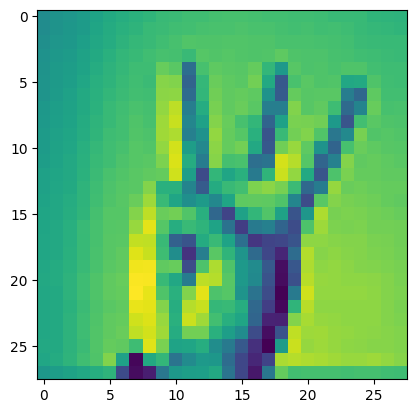

In [14]:
for i, j in train_data:
  temp_img = i

  plt.imshow(temp_img.permute(1,2,0))
  break

# Model Building

In [15]:
class SignLabelModel(nn.Module):
    def __init__(self, num_classes):
        super(SignLabelModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
  # Number of classes
model = SignLabelModel(NUM_CLASS).to(device)

In [16]:
num_epochs = 20
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [17]:
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 3.1156
Epoch [1/20], Loss: 2.7923
Epoch [1/20], Loss: 2.2005
Epoch [1/20], Loss: 2.1628
Epoch [1/20], Loss: 1.7421
Epoch [1/20], Loss: 1.3214


  5%|▌         | 1/20 [00:12<03:59, 12.60s/it]

Epoch [2/20], Loss: 1.4470
Epoch [2/20], Loss: 1.4274
Epoch [2/20], Loss: 1.1627
Epoch [2/20], Loss: 1.1248
Epoch [2/20], Loss: 0.9075
Epoch [2/20], Loss: 0.7576


 10%|█         | 2/20 [00:23<03:26, 11.50s/it]

Epoch [3/20], Loss: 1.2222
Epoch [3/20], Loss: 1.0192
Epoch [3/20], Loss: 0.7705
Epoch [3/20], Loss: 0.8673
Epoch [3/20], Loss: 0.6314
Epoch [3/20], Loss: 0.4790


 15%|█▌        | 3/20 [00:34<03:13, 11.41s/it]

Epoch [4/20], Loss: 0.7721
Epoch [4/20], Loss: 0.5677
Epoch [4/20], Loss: 0.4645
Epoch [4/20], Loss: 0.6171
Epoch [4/20], Loss: 0.8121
Epoch [4/20], Loss: 0.3803


 20%|██        | 4/20 [00:46<03:03, 11.49s/it]

Epoch [5/20], Loss: 0.7502
Epoch [5/20], Loss: 0.7197
Epoch [5/20], Loss: 0.5172
Epoch [5/20], Loss: 0.8239
Epoch [5/20], Loss: 0.5264
Epoch [5/20], Loss: 0.2061


 25%|██▌       | 5/20 [00:57<02:52, 11.51s/it]

Epoch [6/20], Loss: 0.6242
Epoch [6/20], Loss: 0.6038
Epoch [6/20], Loss: 0.6796
Epoch [6/20], Loss: 0.5018
Epoch [6/20], Loss: 0.3997
Epoch [6/20], Loss: 0.3159


 30%|███       | 6/20 [01:09<02:40, 11.49s/it]

Epoch [7/20], Loss: 0.5751
Epoch [7/20], Loss: 0.4470
Epoch [7/20], Loss: 0.2512
Epoch [7/20], Loss: 0.4057
Epoch [7/20], Loss: 0.3637
Epoch [7/20], Loss: 0.1110


 35%|███▌      | 7/20 [01:20<02:29, 11.48s/it]

Epoch [8/20], Loss: 0.2979
Epoch [8/20], Loss: 0.4927
Epoch [8/20], Loss: 0.3412
Epoch [8/20], Loss: 0.3850
Epoch [8/20], Loss: 0.2373
Epoch [8/20], Loss: 0.3020


 40%|████      | 8/20 [01:31<02:15, 11.25s/it]

Epoch [9/20], Loss: 0.5934
Epoch [9/20], Loss: 0.3758
Epoch [9/20], Loss: 0.2443
Epoch [9/20], Loss: 0.3774
Epoch [9/20], Loss: 0.2900
Epoch [9/20], Loss: 0.2774


 45%|████▌     | 9/20 [01:42<02:03, 11.23s/it]

Epoch [10/20], Loss: 0.3032
Epoch [10/20], Loss: 0.2848
Epoch [10/20], Loss: 0.1641
Epoch [10/20], Loss: 0.4608
Epoch [10/20], Loss: 0.2349
Epoch [10/20], Loss: 0.1015


 50%|█████     | 10/20 [01:54<01:53, 11.33s/it]

Epoch [11/20], Loss: 0.2726
Epoch [11/20], Loss: 0.3300
Epoch [11/20], Loss: 0.1369
Epoch [11/20], Loss: 0.4660
Epoch [11/20], Loss: 0.3194
Epoch [11/20], Loss: 0.1320


 55%|█████▌    | 11/20 [02:05<01:42, 11.38s/it]

Epoch [12/20], Loss: 0.0719
Epoch [12/20], Loss: 0.3109
Epoch [12/20], Loss: 0.1430
Epoch [12/20], Loss: 0.2684
Epoch [12/20], Loss: 0.1298
Epoch [12/20], Loss: 0.1407


 60%|██████    | 12/20 [02:17<01:31, 11.46s/it]

Epoch [13/20], Loss: 0.2400
Epoch [13/20], Loss: 0.1748
Epoch [13/20], Loss: 0.0689
Epoch [13/20], Loss: 0.2909
Epoch [13/20], Loss: 0.0917
Epoch [13/20], Loss: 0.1209


 65%|██████▌   | 13/20 [02:29<01:21, 11.60s/it]

Epoch [14/20], Loss: 0.2410
Epoch [14/20], Loss: 0.1426
Epoch [14/20], Loss: 0.0860
Epoch [14/20], Loss: 0.2378
Epoch [14/20], Loss: 0.1222
Epoch [14/20], Loss: 0.1300


 70%|███████   | 14/20 [02:40<01:09, 11.56s/it]

Epoch [15/20], Loss: 0.1698
Epoch [15/20], Loss: 0.0744
Epoch [15/20], Loss: 0.1231
Epoch [15/20], Loss: 0.1864
Epoch [15/20], Loss: 0.1680
Epoch [15/20], Loss: 0.0311


 75%|███████▌  | 15/20 [02:51<00:56, 11.34s/it]

Epoch [16/20], Loss: 0.2221
Epoch [16/20], Loss: 0.1465
Epoch [16/20], Loss: 0.0474
Epoch [16/20], Loss: 0.0879
Epoch [16/20], Loss: 0.1699
Epoch [16/20], Loss: 0.0689


 80%|████████  | 16/20 [03:03<00:46, 11.53s/it]

Epoch [17/20], Loss: 0.1194
Epoch [17/20], Loss: 0.0732
Epoch [17/20], Loss: 0.0501
Epoch [17/20], Loss: 0.1237
Epoch [17/20], Loss: 0.0661
Epoch [17/20], Loss: 0.0610


 85%|████████▌ | 17/20 [03:15<00:34, 11.58s/it]

Epoch [18/20], Loss: 0.1075
Epoch [18/20], Loss: 0.0480
Epoch [18/20], Loss: 0.2867
Epoch [18/20], Loss: 0.1330
Epoch [18/20], Loss: 0.1496
Epoch [18/20], Loss: 0.0863


 90%|█████████ | 18/20 [03:27<00:23, 11.64s/it]

Epoch [19/20], Loss: 0.1489
Epoch [19/20], Loss: 0.2584
Epoch [19/20], Loss: 0.0512
Epoch [19/20], Loss: 0.2080
Epoch [19/20], Loss: 0.0956
Epoch [19/20], Loss: 0.0396


 95%|█████████▌| 19/20 [03:38<00:11, 11.68s/it]

Epoch [20/20], Loss: 0.0326
Epoch [20/20], Loss: 0.0848
Epoch [20/20], Loss: 0.2347
Epoch [20/20], Loss: 0.0542
Epoch [20/20], Loss: 0.0268
Epoch [20/20], Loss: 0.0360


100%|██████████| 20/20 [03:50<00:00, 11.52s/it]

Training finished.
